In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import localSettings as ls
print(ls.main_path)

/Users/elenag/Desktop/PlotterLEE/


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights("/Users/elenag/Desktop/PlotterLEE/NuMIFlux/NuMIFluxBeamVar/Systematics/NuMI_Beamline_Variations_to_CV_Ratios.root","RHC")


In [5]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 03012021


In [6]:
SHRCALIBFACTOR = 1.00

In [7]:
# USING BDT?
USEBDT = True

In [8]:
# Doing Run3?
ISRUN3 = False

In [9]:
# scale to MCC8 CV?
MCC8WEIGHTS = False

In [10]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [11]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [12]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return dot_product # angle*180/3.14159265



In [13]:
from load_data_run1234 import process_uproot as process_uproot
from load_data_run1234 import process_uproot_recoveryvars as process_uproot_recoveryvars

In [14]:
tree = "NeutrinoSelectionFilter"

#new
BNB  = 'run3/neutrinoselection_filt_run3b_beamon_beamgood' +ls.APPEND
EXT  = 'run3/neutrinoselection_filt_run3b_beamoff'         +ls.APPEND
NU   = 'run3/neutrinoselection_filt_run3b_overlay'    +ls.APPEND #newTune
NUE  = 'run3/neutrinoselection_filt_run3b_overlay_intrinsic'+ls.APPEND #newTune
DRT  = 'run3/neutrinoselection_filt_run3b_dirt_overlay'        +ls.APPEND



mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]
uproot_v = [mc,nue,ext,data,dirt]


variables = [
    "nu_pdg", "slpdg", "trk_score_v", "backtracked_pdg","true_nu_px","true_nu_py","true_nu_pz",
    "category", "ccnc", "true_nu_vtx_z","true_nu_vtx_y","true_nu_vtx_x",
    "crtveto","crthitpe","_closestNuCosmicDist",
    "NeutrinoEnergy0","NeutrinoEnergy1","NeutrinoEnergy2",
    "run","sub","evt",
    "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
    "nu_flashmatch_score","best_cosmic_flashmatch_score","best_obviouscosmic_flashmatch_score",
    "trk_llr_pid_score_v", # trk-PID score
    "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "nproton", "nu_e", 
    "hits_u", "hits_v", "hits_y", 
    "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
    "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
    "pi0_e", "evnunhits", "nslice", "interaction",
    "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
    "trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v",
    "trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v",
    "trk_start_x_v","trk_start_z_v", "trk_start_y_v",
    "topological_score"
]



'''
WEIGHTS = ["weightSpline","weightTune","weightSplineTimesTune", "weightsGenie", "weightsFlux", "weightsReint"]
WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight", "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
           "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
           "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


WEIGHTS = ["weightSpline","weightTune","weightSplineTimesTune"]#, "weightsGenie", "weightsFlux", "weightsReint"]
WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
           "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
           "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]
SYSTEMATICS = ['weightsFlux','weightsGenie']

'''

WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 

WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

RCVRYVARS = ["shr_energy_tot", "trk_energy_tot",
             "trk_end_x_v","trk_end_y_v","trk_end_z_v",
             "trk_phi_v","trk_theta_v","trk_len_v","trk_id",
             "shr_px","shr_py","shr_pz","shr_start_x","shr_start_y","shr_start_z","trk_hits_max",
             #"shr_tkfit_dedx_u_v","shr_tkfit_dedx_v_v","shr_tkfit_dedx_y_v",
             #"shr_tkfit_dedx_nhits_u_v","shr_tkfit_dedx_nhits_v_v","shr_tkfit_dedx_nhits_y_v"
]

NUEVARS = ["shr_dedx_Y", "shr_bkt_pdg", "shr_theta",#"shr_pfp_id_v",
           "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
           "shr_tkfit_gap10_dedx_U","shr_tkfit_gap10_dedx_V","shr_tkfit_gap10_dedx_Y",
           "shr_tkfit_2cm_dedx_U","shr_tkfit_2cm_dedx_V","shr_tkfit_2cm_dedx_Y",
           "shrmoliereavg","shrmoliererms",
           "shr_tkfit_npointsvalid","shr_tkfit_npoints", # fitted vs. all hits for shower
           "shrclusfrac0","shrclusfrac1","shrclusfrac2", # track-fitted hits / all hits
           "trkshrhitdist2", "trkshrhitdist0","trkshrhitdist1", #distance between track and shower in 2D
           "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
           "secondshower_U_nhit","secondshower_U_vtxdist","secondshower_U_dot","secondshower_U_dir","shrclusdir0",
           "secondshower_V_nhit","secondshower_V_vtxdist","secondshower_V_dot","secondshower_V_dir","shrclusdir1",
           "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","secondshower_Y_dir","shrclusdir2",
           "shrMCSMom","DeltaRMS2h","shrPCA1CMed_5cm","CylFrac2h_1cm",
           "shr_hits_tot", "shr_hits_u_tot", "shr_hits_v_tot", "shr_hits_y_tot",
           "shr_theta_v","shr_phi_v","shr_energy_y_v","n_tracks",
           "shr_start_x_v","shr_start_z_v","shr_start_z_v",
           "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "trk_bkt_pdg",  
           "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
           "n_showers_contained", "shr_distance", "trk_distance",
           "matched_E", "shr_bkt_E", "trk_bkt_E",
           "shr_tkfit_nhits_Y","shr_tkfit_nhits_U","shr_tkfit_nhits_V",
           "shr_tkfit_2cm_nhits_Y","shr_tkfit_2cm_nhits_U","shr_tkfit_2cm_nhits_V",
           "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V",
           "trk_energy", "tksh_distance", "tksh_angle","contained_fraction",
           "shr_score", "trk_score", "trk_hits_tot","trk_len",
           "trk_hits_tot", "trk_hits_u_tot", "trk_hits_v_tot", "trk_hits_y_tot",
           "shr_energy_tot_cali", "shr_dedx_Y_cali", "trk_energy_tot","shr_id",
           "hits_ratio", "n_tracks_contained",
           "p", "pt", "selected","trk_theta_v","trk_phi_v","trk_score_v","trk_llr_pid_score_v","trk_energy_proton_v",
           "trk_calo_energy_y_v","trk_id","n_tracks_contained","trk_theta_v","trk_phi_v"
]




    
#make the list unique
variables += NUEVARS
variables += RCVRYVARS
variables = list(set(variables))
print(variables)

#if not ISRUN3:
variables.remove("_closestNuCosmicDist")
variables.remove("crtveto")
variables.remove("crthitpe")

nue  = nue.pandas.df(variables + WEIGHTS + SYSTEMATICS + PPFX, flatten=False)
mc   = mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX, flatten=False)
data = data.pandas.df(variables, flatten=False)
ext  = ext.pandas.df(variables, flatten=False)
dirt = dirt.pandas.df(variables + WEIGHTS + SYSTEMATICS, flatten=False)


['shr_tkfit_gap10_nhits_U', 'shrclusfrac2', 'shr_distance', 'nu_e', 'shr_tkfit_npoints', 'CosmicIP', 'shr_tkfit_dedx_U', 'trk_end_y_v', 'reco_nu_vtx_sce_x', 'trkshrhitdist1', 'shr_bkt_E', 'CosmicDirAll3D', 'trk_hits_max', 'trk_start_y_v', 'shr_tkfit_2cm_dedx_Y', 'shrmoliereavg', 'shr_tkfit_dedx_Y', '_opfilter_pe_veto', 'npi0', 'shr_start_z_v', 'trk_len_v', 'reco_nu_vtx_x', 'trk_sce_start_y_v', 'shr_tkfit_gap10_dedx_U', 'secondshower_V_dir', 'trk_id', 'crthitpe', 'n_showers_contained', 'shr_px', 'shr_pz', 'contained_fraction', 'interaction', 'shrclusdir1', 'NeutrinoEnergy0', 'trk_score_v', 'shr_tkfit_npointsvalid', 'secondshower_U_dot', 'shr_tkfit_gap10_dedx_V', 'shr_tkfit_gap10_nhits_Y', 'shrclusdir2', 'true_nu_px', 'run', 'secondshower_V_vtxdist', 'shrmoliererms', 'trkshrhitdist2', 'shr_tkfit_2cm_dedx_U', 'nu_pdg', 'shr_tkfit_nhits_V', 'selected', 'trk_hits_y_tot', 'backtracked_pdg', 'npion', 'trk_calo_energy_y_v', 'shrclusfrac0', 'trk_hits_tot', 'shr_py', 'slpdg', 'reco_nu_vtx_z', 's

In [15]:
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 

    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    df[ 'weightSplineTimesPPFX' ]          = df[ 'weightSpline' ]*df['ppfx_cv']
    
    # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.



In [16]:
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['shr_Angle_Numi_target'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)

In [17]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

df_v = [mc,nue,ext,data,dirt]
#df_v = [lee,mc,nue,ext,data,dirt]

for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['protonenergy'] = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit'] = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y'] = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    df['anglediff_V'] = np.abs(df['secondshower_V_dir']-df['shrclusdir1'])
    df['anglediff_U'] = np.abs(df['secondshower_U_dir']-df['shrclusdir0'])
    df['trkthetacos'] = np.cos(df['trk_theta'])


    #df['FMdiffOBV'] = df['nu_flashmatch_score']-df['best_obviouscosmic_flashmatch_score']
    #df['FMdiff'] = df['nu_flashmatch_score']-df['best_cosmic_flashmatch_score']

In [18]:
# Calculate the true neutrino direction off of the NuMI beam
dfmc_v = [mc,nue,dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

In [19]:
for i,df in enumerate(df_v):
    up = uproot_v[i]
    #trk_score_v = up.array('trk_score_v')
    trk_sce_start_x_v = up.array('trk_sce_start_x_v')
    trk_sce_start_y_v = up.array('trk_sce_start_y_v')
    trk_sce_start_z_v = up.array('trk_sce_start_z_v')
    trk_sce_end_x_v = up.array('trk_sce_end_x_v')
    trk_sce_end_y_v = up.array('trk_sce_end_y_v')
    trk_sce_end_z_v = up.array('trk_sce_end_z_v')
    shr_id = up.array('shr_id')-1 # I think we need this -1 to get the right result
    #trk_score_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_score_v,shr_id)])
    trk_sce_start_x_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_x_v,shr_id)])
    trk_sce_start_y_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_y_v,shr_id)])
    trk_sce_start_z_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_z_v,shr_id)])
    trk_sce_end_x_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_x_v,shr_id)])
    trk_sce_end_y_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_y_v,shr_id)])
    trk_sce_end_z_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_z_v,shr_id)])
    #df['shr_score_check'] = trk_score_v_sel
    df['shr_trk_sce_start_x'] = trk_sce_start_x_v_sel
    df['shr_trk_sce_start_y'] = trk_sce_start_y_v_sel
    df['shr_trk_sce_start_z'] = trk_sce_start_z_v_sel
    df['shr_trk_sce_end_x'] = trk_sce_end_x_v_sel
    df['shr_trk_sce_end_y'] = trk_sce_end_y_v_sel
    df['shr_trk_sce_end_z'] = trk_sce_end_z_v_sel   

In [20]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    #
    # secondshower_U/V/Y_dot need to be set to 9999. to match data ntuples produced with v08_00_00_43 or later;
    # the patch below is valid only to match data ntuples produced with v08_00_00_42.
    #
    #df.loc[df['secondshower_U_dot'].isna(),'secondshower_U_dot'] = 0.0 #for 0p please uncomment
    #df.loc[df['secondshower_V_dot'].isna(),'secondshower_V_dot'] = 0.0 #for 0p please uncomment
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [21]:
#
for i,df in enumerate(df_v):
    up = uproot_v[i]
    df["slclnhits"] = up.array("pfnhits").sum()
    df["slclnunhits"] = up.array("pfnunhits").sum()
#

In [22]:
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
    df['shr_tkfit_dedx_avg'] = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
    df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
    df['shr_tkfit_2cm_dedx_avg'] = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
    df['shr_tkfit_gap10_dedx_avg'] = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [23]:
INTERCEPT = 0.0
SLOPE = 0.83

# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"] = np.ones_like(ext["shr_energy"])

# test calibrating dedx on Y plane
#data["shr_tkfit_gap10_dedx_Y"] = data["shr_tkfit_gap10_dedx_Y"]*1.03
#ext["shr_tkfit_gap10_dedx_Y"] = ext["shr_tkfit_gap10_dedx_Y"]*1.03
#data["shr_tkfit_2cm_dedx_Y"] = data["shr_tkfit_2cm_dedx_Y"]*1.03
#ext["shr_tkfit_2cm_dedx_Y"] = ext["shr_tkfit_2cm_dedx_Y"]*1.03
#data["shr_tkfit_dedx_Y"] = data["shr_tkfit_dedx_Y"]*1.03
#ext["shr_tkfit_dedx_Y"] = ext["shr_tkfit_dedx_Y"]*1.03

In [24]:
# add back the cosmic category, for background only
df_v = [mc,nue,ext,data,dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [25]:
data["is_signal"] = data["category"] == 11
nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11


In [26]:
# 1eNp variables to be trained on
#TRAINVAR = ["shr_score","tksh_distance","tksh_angle",
#            "shr_tkfit_dedx_max","trkfit","trkpid",
#            "subcluster","shrmoliereavg",
#            "trkshrhitdist2","hits_ratio",
#            "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","anglediff_Y",
#            "CosmicIPAll3D","CosmicDirAll3D"]

#1e0p
TRAINVAR = [#'tksh_angle','trkpid',
            #'shrmoliererms',
            'shrmoliereavg','shr_score', "trkfit","subcluster",
            "CosmicIPAll3D","CosmicDirAll3D",
            'secondshower_Y_nhit','secondshower_Y_vtxdist','secondshower_Y_dot','anglediff_Y',
            'secondshower_V_nhit','secondshower_V_vtxdist','secondshower_V_dot','anglediff_V',
            'secondshower_U_nhit','secondshower_U_vtxdist','secondshower_U_dot','anglediff_U',
            "shr_tkfit_2cm_dedx_U", "shr_tkfit_2cm_dedx_V", "shr_tkfit_2cm_dedx_Y",
            "shr_tkfit_gap10_dedx_U", "shr_tkfit_gap10_dedx_V", "shr_tkfit_gap10_dedx_Y",
            "shrMCSMom",
            "DeltaRMS2h",
            "shrPCA1CMed_5cm",
            "CylFrac2h_1cm"#,
            #"shr_tkfit_gap10_nhits_tot","shr_tkfit_2cm_nhits_tot",
            #"n_showers_contained","tksh_distance",
            #"trkshrhitdist2",
            #"hits_ratio",
            #"is_signal","train_weight","nu_e"
           ]

In [27]:
LABELS = ['bkg']


if (USEBDT == True):
    for label, bkg_query in zip(LABELS, nue_booster.bkg_queries):
        with open(ls.pickle_path+'mcs_noext_200326/'+'booster_%s_0304_extnumi_vx.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            #print((ls.pickle_path+'booster_%s_0304_extnumi.model' % label), booster.best_iteration)
            #booster.save_model( (ls.pickle_path+'booster_%s_0304_extnumi.model' % label) )
            mc[label+"_score"] = booster.predict(
                xgb.DMatrix(mc[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            nue[label+"_score"] = booster.predict(
                xgb.DMatrix(nue[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            ext[label+"_score"] = booster.predict(
                xgb.DMatrix(ext[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            data[label+"_score"] = booster.predict(
                xgb.DMatrix(data[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            dirt[label+"_score"] = booster.predict(
                xgb.DMatrix(dirt[TRAINVAR]),
                ntree_limit=booster.best_iteration)


In [28]:
dfbdt_v = [mc,nue,ext,data,dirt]
print(mc.shape)
print(nue.shape)
print(ext.shape)
print(data.shape)
print(dirt.shape)

from load_data_run1234 import process_uproot as process_uproot
from load_data_run1234 import process_uproot_recoveryvars as process_uproot_recoveryvars
for i,df in enumerate(df_v):
    up = uproot_v[i]
    process_uproot(up,df)

(28653, 237)
(58902, 220)
(10439, 208)
(9281, 208)
(1378, 219)
(28653,) 28653
(58902,) 58902
(10439,) 10439
(9281,) 9281
(1378,) 1378


In [29]:
df_v = [mc,nue,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']

In [30]:
df_v = [mc,nue]
scaleFlat = 1
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        


In [31]:

# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!
import time
s = time.time()
df_v = [mc,nue,ext,data,dirt]
print(data.shape)
print(ext.shape)
print(nue.shape)
print(mc.shape)
puppa1 = 'trk_score_v'
#print ('trk_llr_pid_score_v' in nue.columns.to_list())


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    print(trk_score_v.shape, len(trk_llr_pid_v))
#    print(len(c), len(trk_id), len(trk_llr_pid_v))
#    for pidv,puppa,tid,cid in zip(trk_llr_pid_v,trk_score_puppa_v,trk_id,c):
#        if len(pidv) > 0:
#            print(len(pidv),len(puppa), pidv,puppa,tid,cid )
#    nnnnnnnPupppppppaaa = 0
#    print(type(trk_llr_pid_v), trk_llr_pid_v.shape)
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    #df['n_proton_cand']   = puppa_proton
    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel


    #print(  df['N_recoShowers'])

for i,df in enumerate(df_v):
    df['shr_numi_Angle']        = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle']     = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)
    df['shr_Angle_Numi_target'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['proton_Angle_Numi_target'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['protontheta'],x['protonphi']) , axis=1)
s2 = time.time()
print (s-s2)

(9281, 223)
(10439, 223)
(58902, 236)
(28653, 253)
(28653,) 28653
(58902,) 58902
(10439,) 10439
(9281,) 9281
(1378,) 1378
-74.06160521507263


# Plotting part

In [32]:
import plotter
import importlib
importlib.reload(plotter)


<module 'plotter' from '/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py'>

In [33]:
import plotter
import importlib
importlib.reload(plotter)
scaling = 1

SPLIT = 1.0
if (USEBDT == True):
    SPLIT = 2.

#nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
# 254.8 & true_nu_vtx_x > -1.55 )")
nueMC = mc.query("(abs(nu_pdg) == 12 & ccnc == 0)")
nue   = nue.query("(abs(nu_pdg) == 12 & ccnc == 0 & true_nu_vtx_z < 1036.8 & true_nu_vtx_z > 0 & true_nu_vtx_y < 116.5 & true_nu_vtx_y > -116.5 & true_nu_vtx_x < \
 254.8 & true_nu_vtx_x > -1.55)")
samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "dirt": dirt,
    "ext": ext
}

scaling = 1
pot =  5.0e20 #partial file: 8.885e+19
mcratio   = pot/1.99076e+21 #norm on wiki: 1.18488e+21; current norm on my plotter:  2.07136e+21
nueratio  = pot/2.5392e+22 #2.59311e+22 #norm for intrinsic = 2.59311e+22
dirtratio = pot/1.03226e+21
extratio  = 10363728.0/32878305.25 #partial file: 2347745.0/4015961.99
SPLIT = 1.0
scalingEXT = 0.98
scalingDRT = 0.35


weights = { #full sample mc = 0.38
            "mc"  : mcratio  * SPLIT * scaling,   
            "nue" : nueratio * SPLIT * scaling,  
            "ext" : extratio * SPLIT * scalingEXT, #set0   
            "dirt": dirtratio* SPLIT * scalingDRT, #set0   
}
print (ext.shape[0])
my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

10439
{'mc': 0.2511603608672065, 'nue': 0.01969124133585381, 'ext': 0.3089104916683624, 'dirt': 0.16953093212950224}


In [34]:
# muon selection
QUERY = 'nslice == 1'
#if ISRUN3: QUERY += ' and ((crtveto!=1) or (crthitpe < 100)) and (_closestNuCosmicDist > 20.)'
#QUERY += ' and trk_len > 20'
#QUERY += ' and topological_score > 0.06'
#QUERY += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251'
#QUERY += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110'
#QUERY += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986'
#QUERY += ' and trkpid > 0.5'
#QUERY += ' and (trkthetacos < 0.853 or trkthetacos > 0.8531)'
#QUERY += ' and bkpdg == 2212 and (trkcompl < 0.5 or trkpur < 0.5)'

print (QUERY)

nslice == 1


In [35]:
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

In [36]:
TWOSHWRS = PRESQ
TWOSHWRS += ' and n_showers_contained >= 2'


In [37]:
# 1eNp preselection
NPPRESQ = PRESQ
NPPRESQ += ' and n_tracks_contained > 0'

In [38]:
# very loose box cuts
NPVLCUTQ = NPPRESQ
NPVLCUTQ += ' and CosmicIPAll3D > 10.'
NPVLCUTQ += ' and trkpid < 0.25'
NPVLCUTQ += ' and hits_ratio > 0.5'
NPVLCUTQ += ' and trkfit < 0.90'
NPVLCUTQ += ' and n_showers_contained == 1'
NPVLCUTQ += ' and tksh_distance < 10.0'
NPVLCUTQ += ' and tksh_angle > -0.9'

In [39]:
# loose box cuts
NPLCUTQ = NPVLCUTQ
NPLCUTQ += ' and CosmicIPAll3D > 10.'
NPLCUTQ += ' and trkpid < 0.02'
NPLCUTQ += ' and hits_ratio > 0.50'
NPLCUTQ += ' and shrmoliereavg < 9'
NPLCUTQ += ' and subcluster > 4'
NPLCUTQ += ' and trkfit < 0.65'
NPLCUTQ += ' and n_showers_contained == 1'
NPLCUTQ += ' and tksh_distance < 6.0'
NPLCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5)'
NPLCUTQ += ' and secondshower_Y_nhit < 50'
NPLCUTQ += ' and tksh_angle > -0.9'

In [40]:
NPLCUTQPlus = NPPRESQ
NPLCUTQPlus += ' and CosmicIPAll3D > 10.'
NPLCUTQPlus += ' and trkpid < 0.25'
NPLCUTQPlus += ' and hits_ratio > 0.5'
NPLCUTQPlus += ' and trkfit < 0.90'
NPLCUTQPlus += ' and tksh_distance < 10.0'
NPLCUTQPlus += ' and tksh_angle > -0.9'
NPLCUTQPlus += ' and CosmicIPAll3D > 10.'
NPLCUTQPlus += ' and trkpid < 0.02'
NPLCUTQPlus += ' and hits_ratio > 0.50'
NPLCUTQPlus += ' and shrmoliereavg < 9'
NPLCUTQPlus += ' and subcluster > 4'
NPLCUTQPlus += ' and trkfit < 0.65'
#NPLCUTQPlus += ' and n_showers_contained > 1'
NPLCUTQPlus += ' and tksh_distance < 6.0'
NPLCUTQPlus += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5)'
NPLCUTQPlus += ' and secondshower_Y_nhit < 50'
NPLCUTQPlus += ' and tksh_angle > -0.9'

In [41]:
# tight box cuts
NPTCUTQ = NPLCUTQ
NPTCUTQ += ' and CosmicIPAll3D > 30.'
NPTCUTQ += ' and CosmicDirAll3D > -0.98 and CosmicDirAll3D < 0.98'
NPTCUTQ += ' and trkpid < 0.02'
NPTCUTQ += ' and hits_ratio > 0.65'
NPTCUTQ += ' and shr_score < 0.25'
NPTCUTQ += ' and shrmoliereavg > 2 and shrmoliereavg < 10'
NPTCUTQ += ' and subcluster > 7'
NPTCUTQ += ' and trkfit < 0.70'
NPTCUTQ += ' and n_showers_contained == 1'
NPTCUTQ += ' and tksh_distance < 4.0'
NPTCUTQ += ' and trkshrhitdist2 < 1.5'
NPTCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 1.0 and shr_tkfit_dedx_max < 3.8)'
NPTCUTQ += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
NPTCUTQ += ' and secondshower_Y_nhit < 30'
NPTCUTQ += ' and tksh_angle > -0.9 and tksh_angle < 0.70'

In [42]:
# OLD loose box cuts
OLCUTQ = PRESQ
OLCUTQ += ' and CosmicIP > 20.'
OLCUTQ += ' and trkpid < 0.1'
OLCUTQ += ' and hits_ratio > 0.5'
OLCUTQ += ' and shr_score < 0.30'
OLCUTQ += ' and n_showers_contained == 1'
OLCUTQ += ' and tksh_distance < 6.0'
OLCUTQ += ' and shr_tkfit_2cm_dedx_avg < 4.0'
OLCUTQ += ' and tksh_angle > -0.9'
# OLD tight box cuts
OTCUTQ = OLCUTQ
OTCUTQ += ' and tksh_distance < 3.5'
OTCUTQ += ' and (shr_tkfit_2cm_dedx_Y > 0 and shr_tkfit_2cm_dedx_Y < 4.0 and shr_tkfit_2cm_dedx_U < 4.0 and shr_tkfit_2cm_dedx_V < 4.0)'
OTCUTQ += ' and (shr_tkfit_gap10_dedx_Y > 0 and shr_tkfit_gap10_dedx_Y < 4.5 and shr_tkfit_gap10_dedx_U < 4.5 and shr_tkfit_gap10_dedx_V < 4.5)'
OTCUTQ += ' and tksh_angle > -0.9 and tksh_angle < 0.75'
OTCUTQ += ' and shrmoliereavg > 2 and shrmoliereavg < 9'
OTCUTQ += ' and trkpid < -0.02'
OTCUTQ += ' and n_showers_contained == 1'
OTCUTQ += ' and shr_score < 0.275'
OTCUTQ += ' and hits_ratio > 0.60'
OTCUTQ += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
OTCUTQ += ' and (trkfit < 0.45 or subcluster > 6)'

In [43]:
# BDT cuts
# 0304 extnumi, pi0 and nonpi0
BDTCQ = NPPRESQ
BDTCQ += ' and pi0_score > 0.67 and nonpi0_score > 0.70'

In [44]:
myPre = "nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0"

In [45]:
# loose box cuts
NPLCUTQ2 = NPPRESQ
NPLCUTQ2 += ' and CosmicIPAll3D > 10.'
NPLCUTQ2 += ' and hits_ratio > 0.5'
NPLCUTQ2 += ' and trkfit < 0.90'
NPLCUTQ2 += ' and n_showers_contained == 1'
NPLCUTQ2 += ' and tksh_distance < 10.0'
NPLCUTQ2 += ' and tksh_angle > -0.9'
NPLCUTQ2 += ' and CosmicIPAll3D > 10.'
#NPLCUTQ2 += ' and trkpid < 0.02'
NPLCUTQ2 += ' and hits_ratio > 0.50'
NPLCUTQ2 += ' and shrmoliereavg < 9'
NPLCUTQ2 += ' and subcluster > 4'
NPLCUTQ2 += ' and trkfit < 0.65'
NPLCUTQ2 += ' and n_showers_contained == 1'
NPLCUTQ2 += ' and tksh_distance < 6.0'
NPLCUTQ2 += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5)'
NPLCUTQ2 += ' and secondshower_Y_nhit < 50'
NPLCUTQ2 += ' and tksh_angle > -0.9'

In [46]:
SCORECUT = 0.5 # 0.75 #75 # max track score                                                                                                                                                                        
DVTX = 3.0 # 3. # distance from vertex of each shower                                                                                                                                                              
VTXDOT = 0.8 # dot product between each shower's direction and the vtx -> shr start vector                                                                                                                         
EMIN1 =  60 #150 #60   # leading photon min energy                                                                                                                                                                        
EMIN2 =  40 #100 #40   # subleading photon min energy                                                                                                                                                          
GAMMADOT = 0.94 #0 #0.94 # max dot product between showres                                                                                                                                                                  
DEDXCUT = 1.0 # MeV/cm cut on leading shower only                                                                                                                                                                  
PI0SEL = 'nslice == 1'
PI0SEL += ' & pi0_shrscore1 < %f & pi0_shrscore2 < %f'%(SCORECUT,SCORECUT)
PI0SEL += '& pi0_dot1  > %f & pi0_dot2 > %f '%(VTXDOT,VTXDOT)
PI0SEL += ' & pi0_radlen1 > %f & pi0_radlen2 > %f & pi0_gammadot < %f '%(DVTX,DVTX,GAMMADOT)
PI0SEL += ' & pi0_energy1_Y > %f & pi0_energy2_Y > %f'%(EMIN1,EMIN2)
#PI0SEL += ' and (filter_pi0 == 1 or bnbdata==1 or extdata==1)'                                                                                                                                                    
#PI0SEL += ' and (filter_pi0 == 1)'                                                                                                                                                                                
PI0SEL += ' and pi0_dedx1_fit_Y >= %f'%DEDXCUT

In [47]:
NUMUOnTheFly = 'nslice == 1 and topological_score > 0.06 '
NUMUOnTheFly += ' and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251'
NUMUOnTheFly += ' and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110'
NUMUOnTheFly += ' and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986'
NUMUOnTheFly += ' and trk_score > 0.8 and trk_len > 10 and trk_distance < 4'

In [48]:
# Define actual selection
# QUERY = NPTCUTQ #NPTCUTQ
#QUERY = NPPRESQ
#QUERY = NPLCUTQ #NPTCUTQ NPLCUTQ
#QUERY = NPPRESQ 
QUERY = NPLCUTQ +" and "+ BDTCQ #PI0SEL#NUMUOnTheFly + ' and n_showers_contained == 1'  #PI0SEL#NPLCUTQ2 #NPLCUTQ #NPPRESQ#'nslice ==1 ' #NPPRESQ #PRESQ
# in case you do not want to look at the data
#QUERY += ' and bnbdata==0'
# in case you want to apply the CRT veto
#if ISRUN3: QUERY += ' and (crtveto!=1) and (_closestNuCosmicDist > 20.)'

In [49]:
print(NPLCUTQPlus)

nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and CosmicIPAll3D > 10. and trkpid < 0.25 and hits_ratio > 0.5 and trkfit < 0.90 and tksh_distance < 10.0 and tksh_angle > -0.9 and CosmicIPAll3D > 10. and trkpid < 0.02 and hits_ratio > 0.50 and shrmoliereavg < 9 and subcluster > 4 and trkfit < 0.65 and tksh_distance < 6.0 and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5) and secondshower_Y_nhit < 50 and tksh_angle > -0.9


In [50]:
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

ZPPRESEL = PRESQ
ZPPRESEL += ' and n_tracks_contained == 0'
ZPPRESEL_one_shower = ZPPRESEL + 'and n_showers_contained == 1'

ZPLOOSESEL = ZPPRESEL
ZPLOOSESEL += ' and n_showers_contained == 1'
ZPLOOSESEL += ' and CosmicIPAll3D > 10.'
ZPLOOSESEL += ' and CosmicDirAll3D > -0.9 and CosmicDirAll3D < 0.9'
ZPLOOSESEL += ' and shrmoliereavg < 15'
ZPLOOSESEL += ' and subcluster > 4'
ZPLOOSESEL += ' and trkfit < 0.65'
ZPLOOSESEL += ' and secondshower_Y_nhit < 50'
ZPLOOSESEL += ' and shr_trk_sce_start_y > -100 and shr_trk_sce_start_y < 80'
ZPLOOSESEL += ' and shr_trk_sce_end_y > -100 and shr_trk_sce_end_y < 100 '
ZPLOOSESEL += ' and shr_trk_len < 300.'
#ZPLOOSESEL += ' and (n_tracks_tot == 0 )'
#ZPLOOSESEL += ' and (n_tracks_tot == 0 or (n_tracks_tot>0 and tk1sh1_angle_alltk>-0.9))'
ZPLOOSESEL += ' and n_tracks_contained == 0'

ZPBDT = ZPLOOSESEL
ZPBDT += ' and bkg_score >0.72'
#ZPBDT += ' and bkg_score >0.5'

QUERY = ZPLOOSESEL

In [51]:
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'

ZPPRESELAlt = PRESQ
ZPLOOSESELAlt  = ZPPRESELAlt
ZPLOOSESELAlt += ' and n_showers_contained == 1'
ZPLOOSESELAlt += ' and CosmicIPAll3D > 10.'
ZPLOOSESELAlt += ' and CosmicDirAll3D > -0.9 and CosmicDirAll3D < 0.9'
ZPLOOSESELAlt += ' and shrmoliereavg < 15'
ZPLOOSESELAlt += ' and subcluster > 4'
ZPLOOSESELAlt += ' and trkfit < 0.65'
ZPLOOSESELAlt += ' and secondshower_Y_nhit < 50'
ZPLOOSESELAlt += ' and shr_trk_sce_start_y > -100 and shr_trk_sce_start_y < 80'
ZPLOOSESELAlt += ' and shr_trk_sce_end_y > -100 and shr_trk_sce_end_y < 100 '
ZPLOOSESELAlt += ' and shr_trk_len < 300.'
#ZPLOOSESEL += ' and (n_tracks_tot == 0 )'
#ZPLOOSESEL += ' and (n_tracks_tot == 0 or (n_tracks_tot>0 and tk1sh1_angle_alltk>-0.9))'
#ZPLOOSESEL += ' and n_tracks_contained == 0'

ZPBDTAlt = ZPLOOSESELAlt
ZPBDTAlt += ' and bkg_score >0.72'


In [52]:
df_v = [mc,nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 9
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 11) & (df['nu_pdg'] ==  12), 'category' ] = 1

/Users/elenag/miniconda3/envs/peleeNB/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [53]:
#this is a BAD BAD thing
df_v = [mc,nue]
for i,df in enumerate(df_v):
    df.loc[ (df['nu_pdg'] == -12), 'category' ] = 11111
    df.loc[ (df['nu_pdg'] ==  12), 'category' ] = 11110


bkg_score > 0.7 and bkg_score <0.9& reco_e <= 4 & reco_e >= 0.4 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:454: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


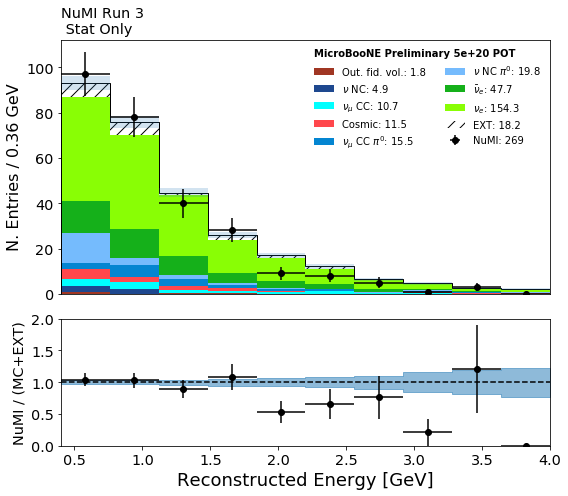

In [83]:
QUERY = "bkg_score > 0.7 and bkg_score <0.9" #
sysBool = False
import matplotlib.pyplot as plt
import matplotlib

VARIABLE, BINS, RANGE, XTIT = 'shr_numi_Angle', 10, (0.,180.), "NuMI Shower Angle [deg]"
VARIABLE, BINS, RANGE, XTIT = 'numi_nu_true_Angle',18,(0,180)," True NuMI Angle "
VARIABLE, BINS, RANGE, XTIT = 'shr_numi_Angle', 10, (0.,180.), "NuMI Shower Angle [deg]"
VARIABLE, BINS, RANGE, XTIT = 'shr_Angle_Numi_target', 10, (-1.,1.), "Shower Directional Cosine from Target Direction"
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',26,(0,260),"vtx x [cm]"
VARIABLE, BINS, RANGE, XTIT = 'bkg_score',10,(0,1.0),"BDT response"
VARIABLE, BINS, RANGE, XTIT = 'nslice',1,(0,1.0),"Simple Count"
VARIABLE, BINS, RANGE, XTIT = 'bkg_score',10,(0,1.0),"BDT response"
VARIABLE, BINS, RANGE, XTIT = 'N_recoProtons',10,(0,10),"N Protons"
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',10,(-120,120),"vtx y [cm]"
VARIABLE, BINS, RANGE, XTIT = 'bkg_score',10,(0,1.0),"BDT response"



VARIABLE, BINS, RANGE, XTIT = 'N_recoProtons',10,(0,10),"N Reco Protons"
VARIABLE, BINS, RANGE, XTIT = 'reco_e', 10, (0.4,4.0), r"Reconstructed Energy [GeV]"
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,#BDTCQ,#NPLCUTQ, #QUERY, #'nslice == 1', #QUERY, #+" and category != 111",
    kind="event_category",
    #kind="sample",
    #kind="interaction",
    #kind='particle_pdg',
    draw_sys=sysBool,
    draw_data=True,
    draw_geoSys = sysBool, 
    stacksort=3,
    genieweight = "weightSplineTimesTuneTimesPPFX", #"weightSplineTimesTuneTimesPPFX", 
    title=XTIT,
    bins=BINS,
    range=RANGE #,
)[0:3]

if sysBool:
    ax1.set_title('NuMI Run 3 \nHP, Beamline Geo, GENIE, G4Reint Systematics',loc='left')
    fig.tight_layout()
    fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/AntiNueXS/Run3/FinalSel/"+VARIABLE+"_Sys.pdf")
else:
    ax1.set_title('NuMI Run 3 \n Stat Only',loc='left')
    fig.tight_layout()
    fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/AntiNueXS/Run3/FinalSel/"+VARIABLE+"_StatOnly.pdf")


bkg_score > 0.7 and bkg_score <0.9 and n_tracks == 0 and reco_e > 0.4& nslice <= 1 & nslice >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
IN COVMATRIX_XS_PPFX
Universes 500
Universes 500
Universes 500
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys


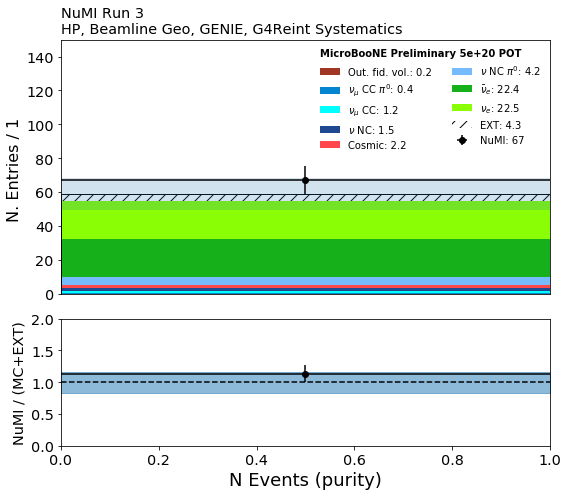

In [94]:
QUERY = "bkg_score > 0.7 and bkg_score <0.9 and n_tracks == 0 and reco_e > 0.4" #
sysBool = False
import matplotlib.pyplot as plt
import matplotlib


VARIABLE, BINS, RANGE, XTIT = 'N_recoProtons',10,(0,10),"N Reco Protons"
VARIABLE, BINS, RANGE, XTIT = 'reco_e', 10, (0.4,4.4), r"Reconstructed Energy [GeV]"
VARIABLE, BINS, RANGE, XTIT = 'nslice', 1, (0,1), r"N Events (purity)"
sysBool = True
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,#BDTCQ,#NPLCUTQ, #QUERY, #'nslice == 1', #QUERY, #+" and category != 111",
    kind="event_category",
    #kind="sample",
    #kind="interaction",
    #kind='particle_pdg',
    draw_sys=sysBool,
    draw_data=True,
    draw_geoSys = sysBool, 
    stacksort=3,
    genieweight = "weightSplineTimesTuneTimesPPFX", #"weightSplineTimesTuneTimesPPFX", 
    title=XTIT,
    bins=BINS,
    range=RANGE #,
)[0:3]

if sysBool:
    ax1.set_title('NuMI Run 3 \nHP, Beamline Geo, GENIE, G4Reint Systematics',loc='left')
    ax1.set_ylim(0,150)
    fig.tight_layout()
    fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/AntiNueXS/Run3/FinalSel/"+VARIABLE+"_zero_0.4-4.4_Sys.pdf")
else:
    ax1.set_title('NuMI Run 3 \n Stat Only',loc='left')
    ax1.set_ylim(0,150)
    fig.tight_layout()
    fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/AntiNueXS/Run3/FinalSel/"+VARIABLE+"_zero_0.4-4.4_StatOnly.pdf")


trk_energy_tot 40 (0, 0.01) tracks energy [GeV]
nslice == 1& trk_energy_tot <= 0.01 & trk_energy_tot >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:252: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:2161: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


shr_tkfit_2cm_dedx_Y 10 (0.5, 10.5) shr tkfit dE/dx (Y, 0-2 cm) [MeV/cm]
nslice == 1& shr_tkfit_2cm_dedx_Y <= 10.5 & shr_tkfit_2cm_dedx_Y >= 0.5 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
shr_tkfit_2cm_dedx_U 10 (0.5, 10.5) shr tkfit dE/dx (U, 0-2 cm) [MeV/cm]
nslice == 1& shr_tkfit_2cm_dedx_U <= 10.5 & shr_tkfit_2cm_dedx_U >= 0.5 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
shr_tkfit_2cm_dedx_V 10 (0.5, 10.5) shr tkfit dE/dx (V, 0-2 cm) [MeV/cm]
nslice == 1& shr_tkfit_2cm_dedx_V <= 10.5 & shr_tkfit_2cm_dedx_V >= 0.5 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
shr_tkfit_gap10_dedx_Y 10 (0.5, 10.5) shr tkfit dE/dx (Y, 1-5 cm) [MeV/cm]
nslice == 1& shr_tkfit_gap10_dedx_Y <= 10.5 & shr_tkfit_gap10_dedx_Y >= 0.5 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
shr_tkfit_gap10_dedx_U 10 (0.5, 10.5) shr tkfit dE/dx (U, 1-5 cm) [MeV/cm]
nslice == 1& shr_tkfit_gap10_dedx_U <= 10.5 & shr_tkfit_gap10_dedx_U >= 0.5 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
shr_tkfit_gap

/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:454: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


secondshower_V_nhit 25 (0, 500) Nhit 2nd shower (V)
nslice == 1& secondshower_V_nhit <= 500 & secondshower_V_nhit >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:454: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )


secondshower_U_nhit 25 (0, 500) Nhit 2nd shower (U)
nslice == 1& secondshower_U_nhit <= 500 & secondshower_U_nhit >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
secondshower_Y_dot 20 (-1, 1) cos(2nd shower direction wrt vtx) (Y)
nslice == 1 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
secondshower_V_dot 20 (-1, 1) cos(2nd shower direction wrt vtx) (V)
nslice == 1 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:1283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 7))


secondshower_U_dot 20 (-1, 1) cos(2nd shower direction wrt vtx) (U)
nslice == 1 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:1283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 7))


secondshower_Y_vtxdist 20 (0.0, 1000) vtx dist 2nd shower (Y)
nslice == 1& secondshower_Y_vtxdist <= 1000 & secondshower_Y_vtxdist >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:1283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 7))


secondshower_V_vtxdist 20 (0.0, 1000) vtx dist 2nd shower (V)
nslice == 1& secondshower_V_vtxdist <= 1000 & secondshower_V_vtxdist >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:1283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 7))
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:454: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:252: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:2161: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


secondshower_U_vtxdist 20 (0.0, 1000) vtx dist 2nd shower (U)
nslice == 1& secondshower_U_vtxdist <= 1000 & secondshower_U_vtxdist >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:1283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 7))
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:454: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:252: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:2161: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


CylFrac2h_1cm 10 (0, 1.0) CylFrac2h 1cm
nslice == 1& CylFrac2h_1cm <= 1 & CylFrac2h_1cm >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:1283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 7))


shrPCA1CMed_5cm 20 (0.5, 1) shrPCA1CMed 5cm
nslice == 1& shrPCA1CMed_5cm <= 1 & shrPCA1CMed_5cm >= 0.5 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:1283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 7))


DeltaRMS2h 20 (0, 20) DeltaRMS2h 1cm
nslice == 1& DeltaRMS2h <= 20 & DeltaRMS2h >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:1283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 7))


shrMCSMom 20 (0, 1000) shrMCSMom 1cm
nslice == 1& shrMCSMom <= 1000 & shrMCSMom >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:1283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 7))


N_recoProtons 10 (0, 10) N Protons
nslice == 1& N_recoProtons <= 10 & N_recoProtons >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:1283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 7))
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:454: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:252: RuntimeWarning: invalid value encountered in true_divide
  return sum(num / den) / len(data)
/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:2161: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bincenters, n_data / n_tot,


bkg_score 10 (0, 1.0) BDT response
nslice == 1& bkg_score <= 1 & bkg_score >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py:1283: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 7))


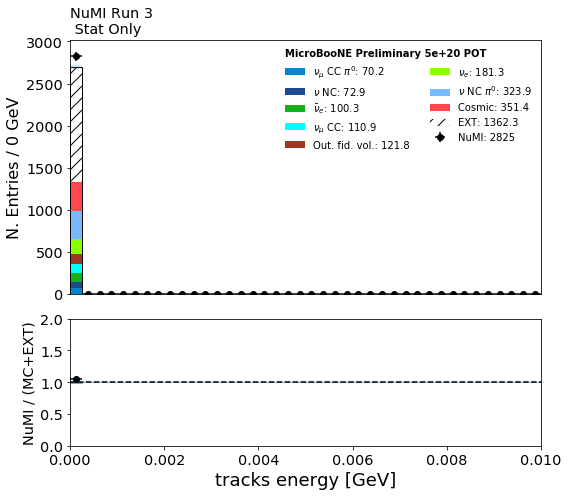

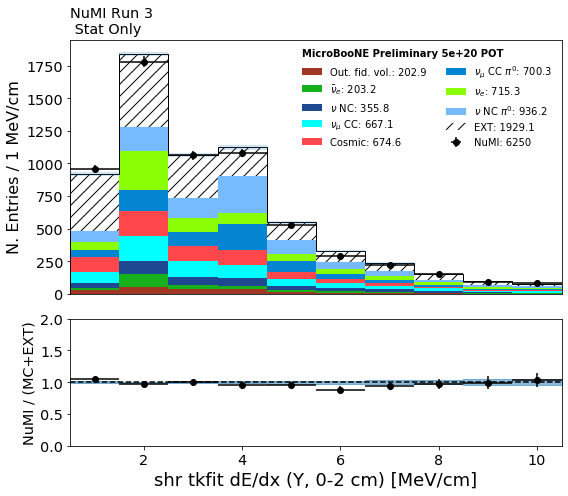

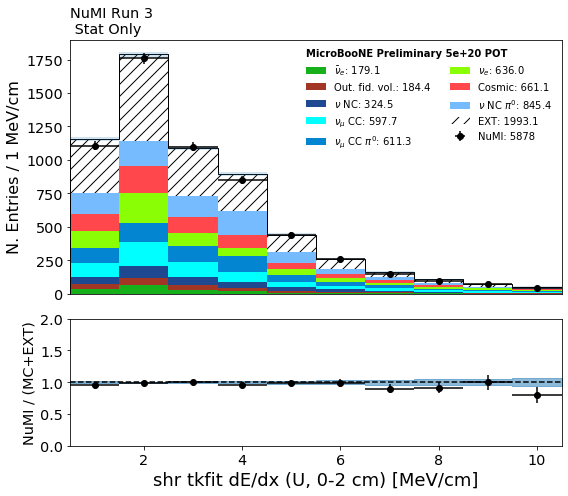

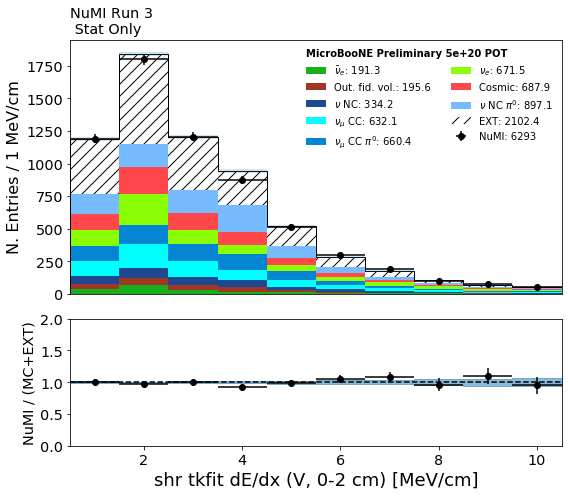

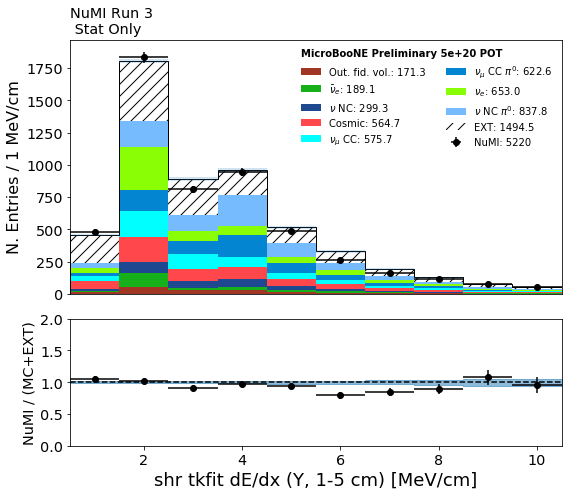

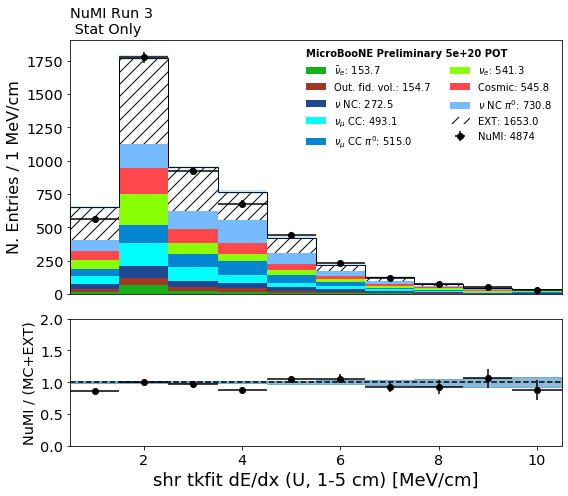

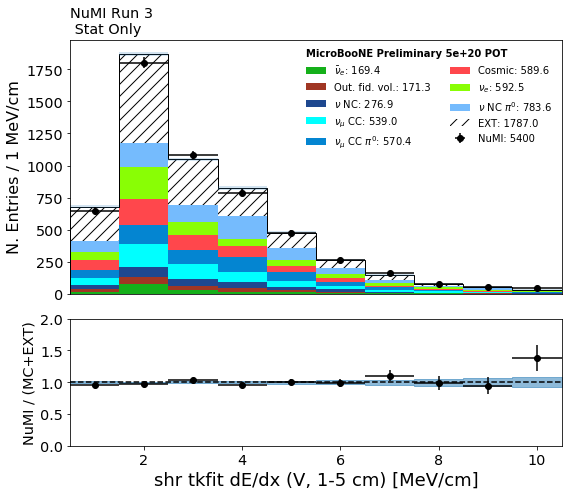

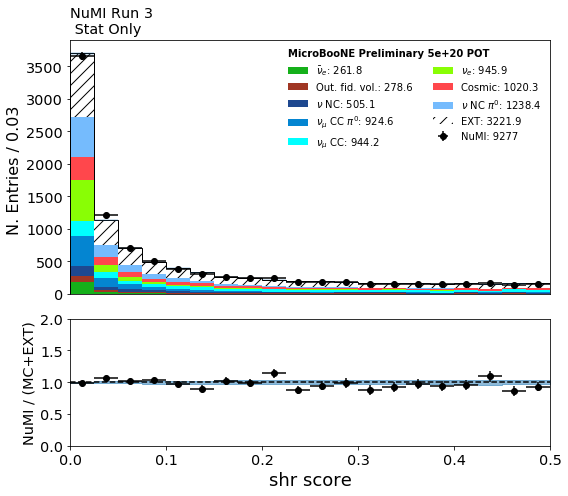

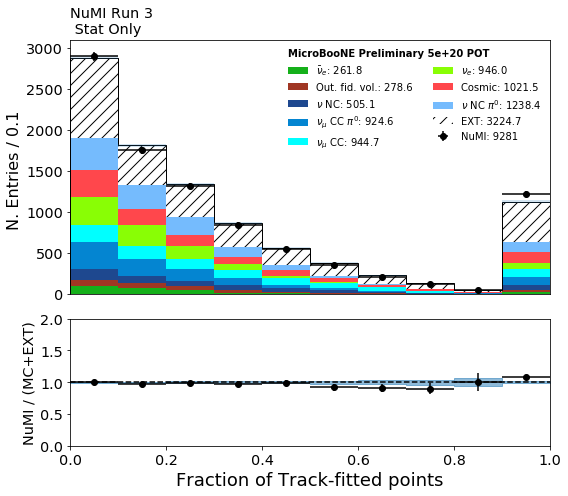

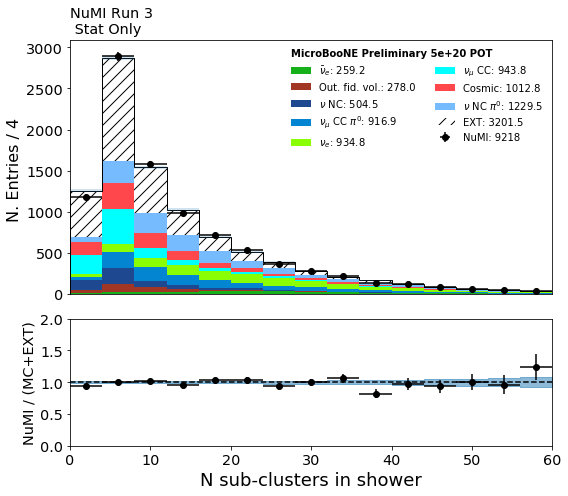

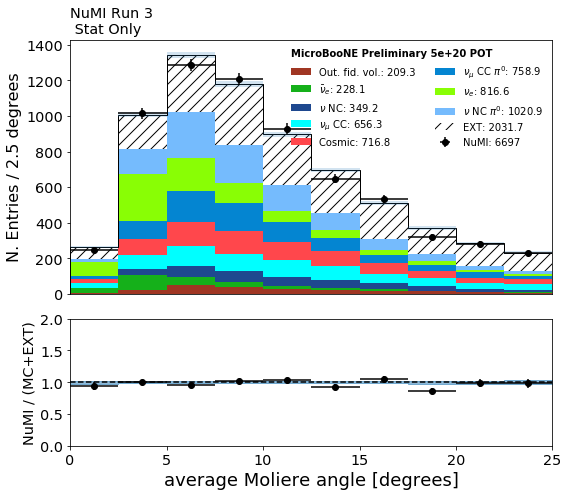

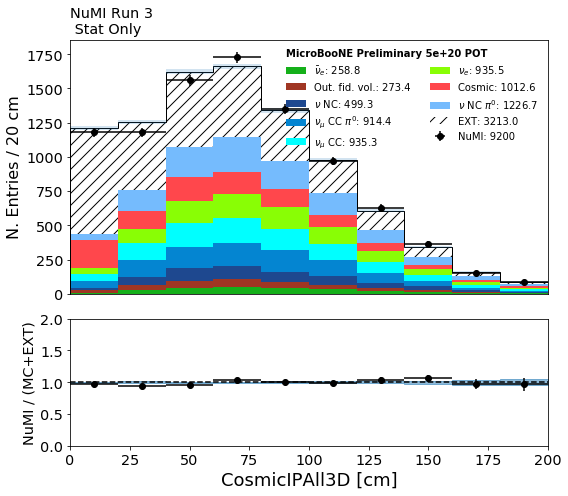

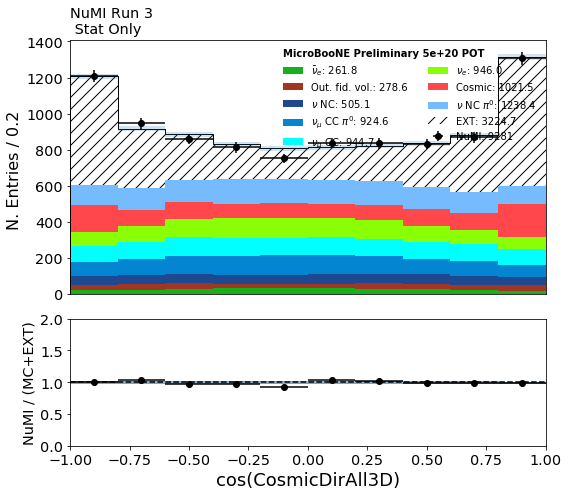

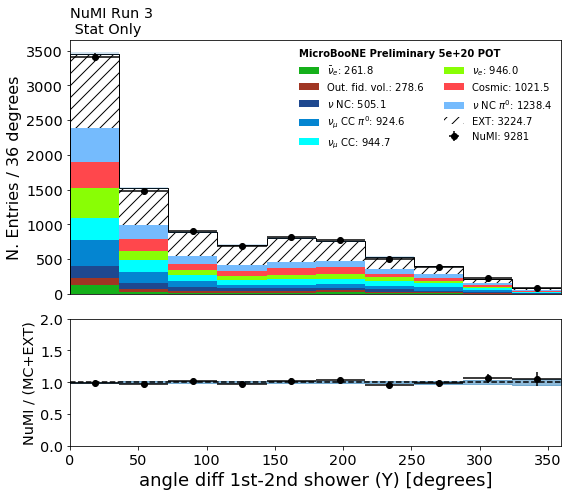

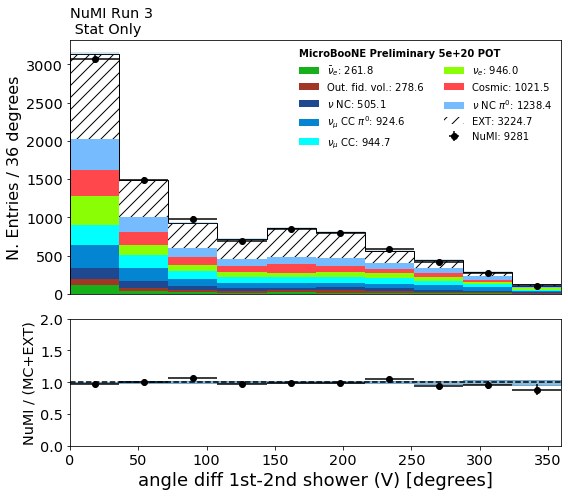

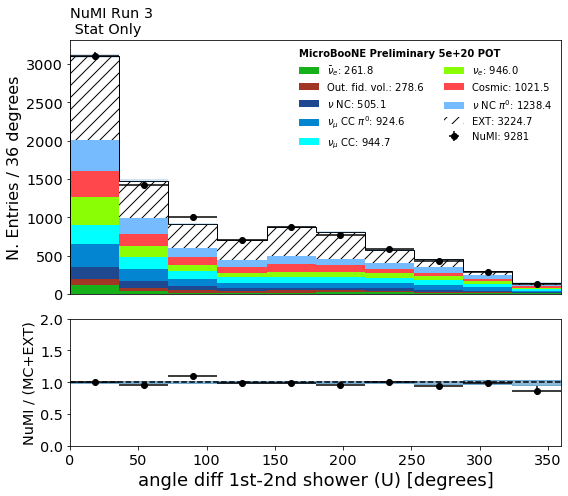

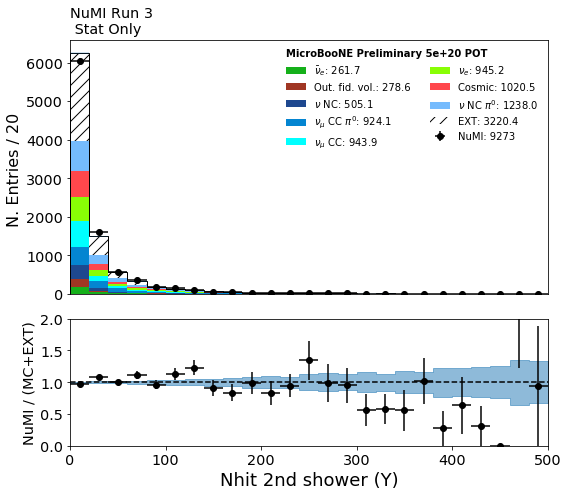

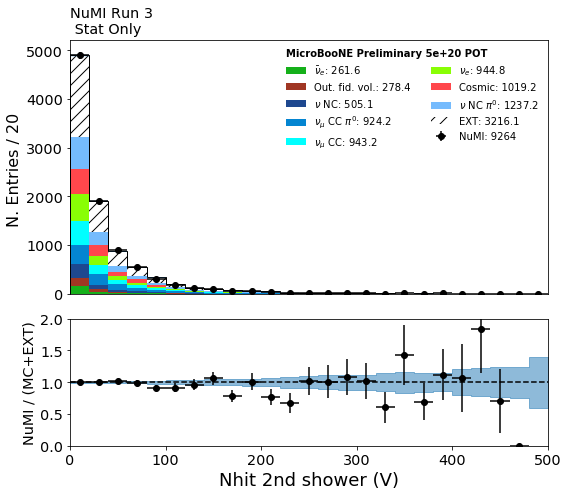

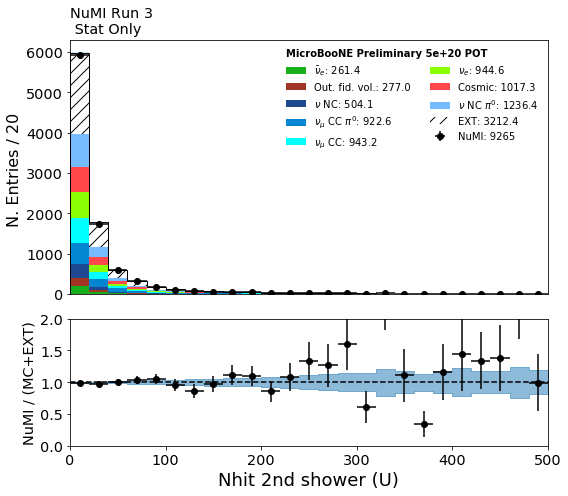

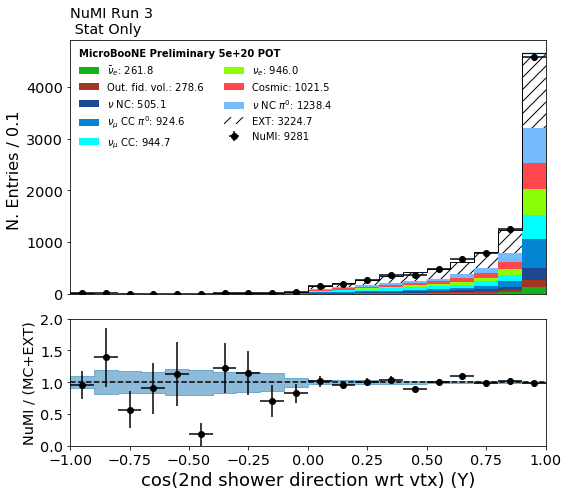

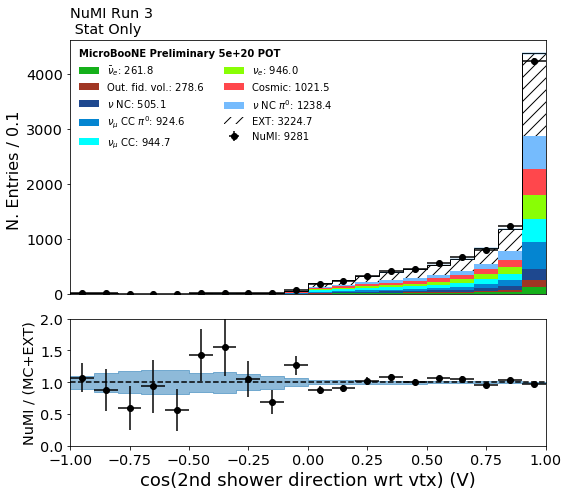

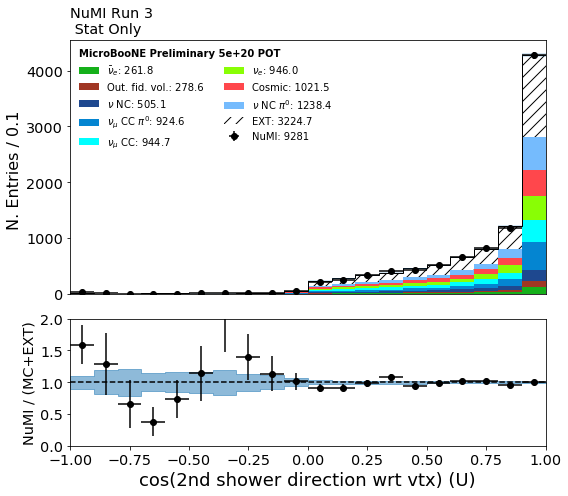

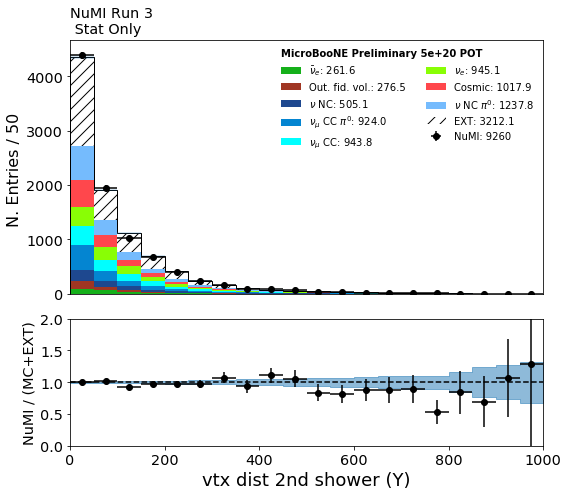

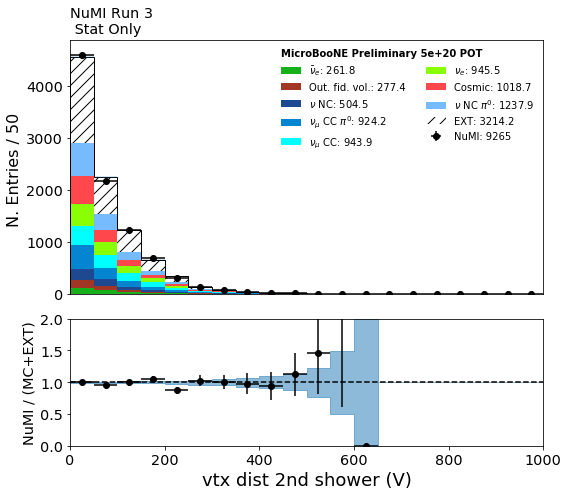

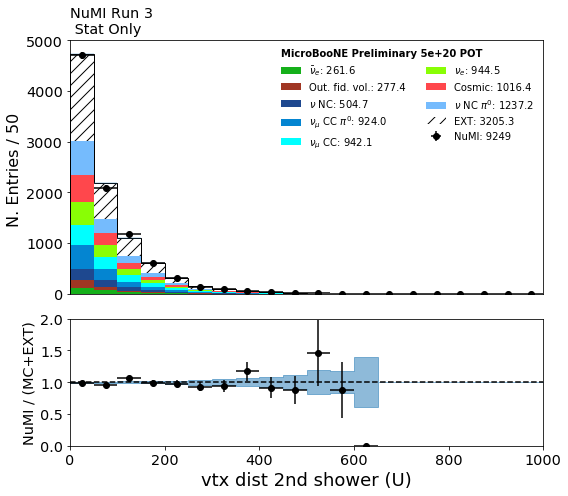

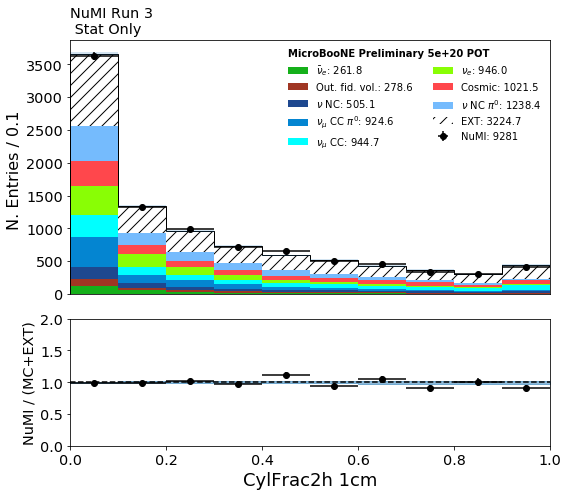

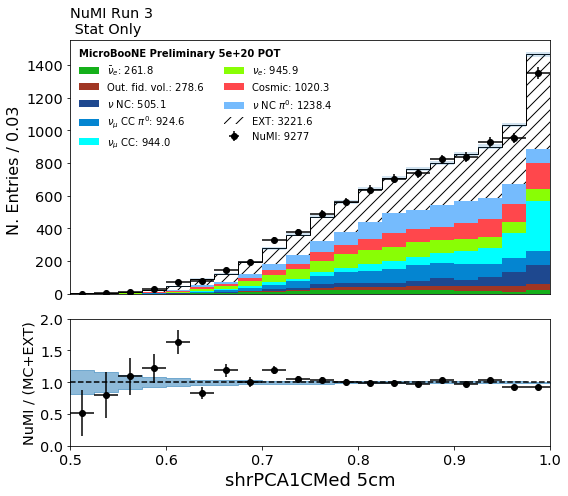

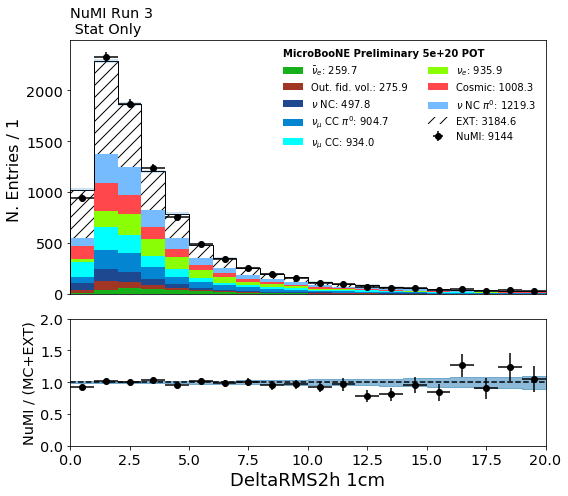

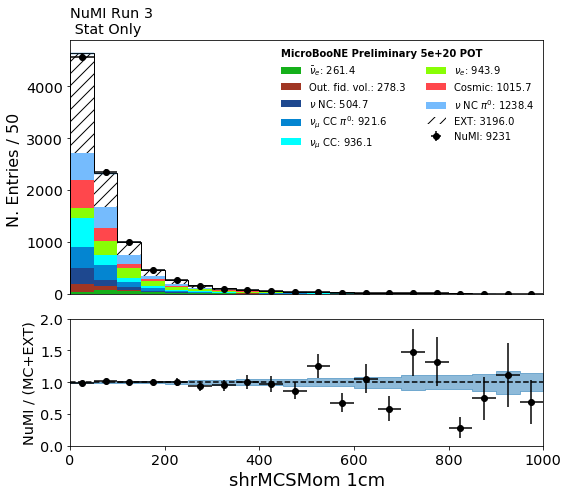

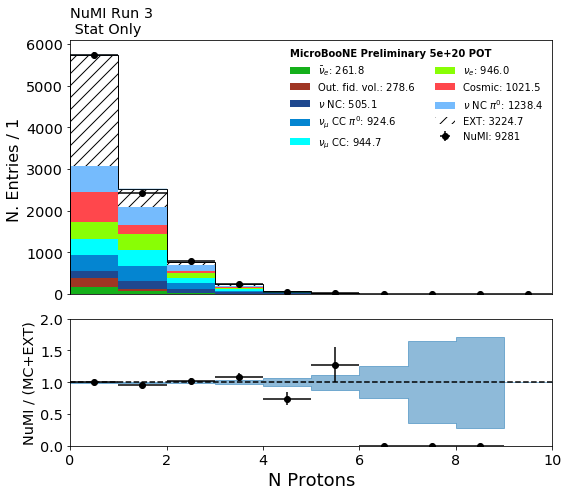

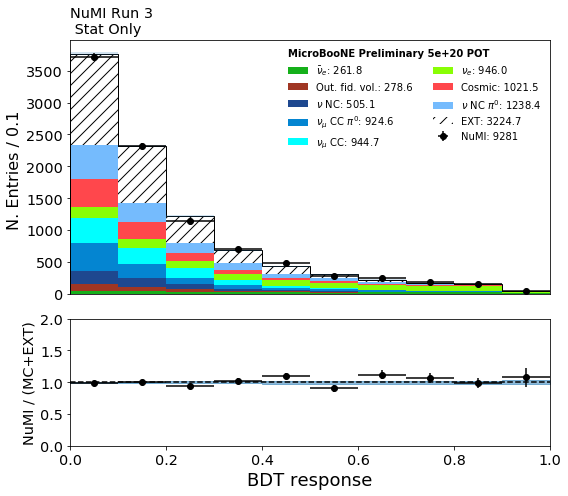

In [71]:
#QUERY += 'and reco_e < 0.15'
QUERY = "nslice == 1" #ZPLOOSESEL #ZPLOOSESEL
plots = [] 
sysBool = False
plots.append(['trk_energy_tot',40,(0,0.01),"tracks energy [GeV]"])
plots.append(['shr_tkfit_2cm_dedx_Y',10,(0.5,10.5),"shr tkfit dE/dx (Y, 0-2 cm) [MeV/cm]"])
plots.append(['shr_tkfit_2cm_dedx_U',10,(0.5,10.5),"shr tkfit dE/dx (U, 0-2 cm) [MeV/cm]"])
plots.append(['shr_tkfit_2cm_dedx_V',10,(0.5,10.5),"shr tkfit dE/dx (V, 0-2 cm) [MeV/cm]"])
plots.append(['shr_tkfit_gap10_dedx_Y',10,(0.5,10.5),"shr tkfit dE/dx (Y, 1-5 cm) [MeV/cm]"])
plots.append(['shr_tkfit_gap10_dedx_U',10,(0.5,10.5),"shr tkfit dE/dx (U, 1-5 cm) [MeV/cm]"])
plots.append(['shr_tkfit_gap10_dedx_V',10,(0.5,10.5),"shr tkfit dE/dx (V, 1-5 cm) [MeV/cm]"])
plots.append(['shr_score',20,(0,0.5),"shr score"])
plots.append(['trkfit',10,(0,1),"Fraction of Track-fitted points"])
plots.append(['subcluster',15,(0,60),"N sub-clusters in shower"])
plots.append(['shrmoliereavg',10,(0,25),"average Moliere angle [degrees]"])
plots.append(['CosmicIPAll3D',10,(0,200),"CosmicIPAll3D [cm]"])
plots.append(['CosmicDirAll3D',10,(-1,1),"cos(CosmicDirAll3D)"])
plots.append(['anglediff_Y',10,(0,360),"angle diff 1st-2nd shower (Y) [degrees]"])
plots.append(['anglediff_V',10,(0,360),"angle diff 1st-2nd shower (V) [degrees]"])
plots.append(['anglediff_U',10,(0,360),"angle diff 1st-2nd shower (U) [degrees]"])
plots.append(['secondshower_Y_nhit',25,(0,500),"Nhit 2nd shower (Y)"])
plots.append(['secondshower_V_nhit',25,(0,500),"Nhit 2nd shower (V)"])
plots.append(['secondshower_U_nhit',25,(0,500),"Nhit 2nd shower (U)"])
plots.append(['secondshower_Y_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (Y)"])
plots.append(['secondshower_V_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (V)"])
plots.append(['secondshower_U_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (U)"])
plots.append(['secondshower_Y_vtxdist',20,(0.,1000),"vtx dist 2nd shower (Y)"])
plots.append(['secondshower_V_vtxdist',20,(0.,1000),"vtx dist 2nd shower (V)"])
plots.append(['secondshower_U_vtxdist',20,(0.,1000),"vtx dist 2nd shower (U)"])
plots.append(['CylFrac2h_1cm',10,(0,1.),"CylFrac2h 1cm"])
plots.append(['shrPCA1CMed_5cm',20,(0.5,1),"shrPCA1CMed 5cm"])
plots.append(['DeltaRMS2h',20,(0,20),"DeltaRMS2h 1cm"])
plots.append(['shrMCSMom',20,(0,1000),"shrMCSMom 1cm"])
plots.append(['N_recoProtons',10,(0,10),"N Protons"])
if USEBDT:
    plots.append(['bkg_score',10,(0,1.0),"BDT response"])
    
    
for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        draw_sys=sysBool,
        draw_geoSys = sysBool, 
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    
    if sysBool:
        ax1.set_title('NuMI Run 3 \nHP, Beamline Geo, GENIE, G4Reint Systematics',loc='left')
        fig.tight_layout()
        fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/AntiNueXS/Run3/PreSel/"+VARIABLE+"_Sys.pdf")
    else:
        ax1.set_title('NuMI Run 3 \n Stat Only',loc='left')
        fig.tight_layout()
        fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/AntiNueXS/Run3/PreSel/"+VARIABLE+"_StatOnly.pdf")
    

bkg_score 50 (0, 1.0) BDT response
nslice == 1& bkg_score <= 1 & bkg_score >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False


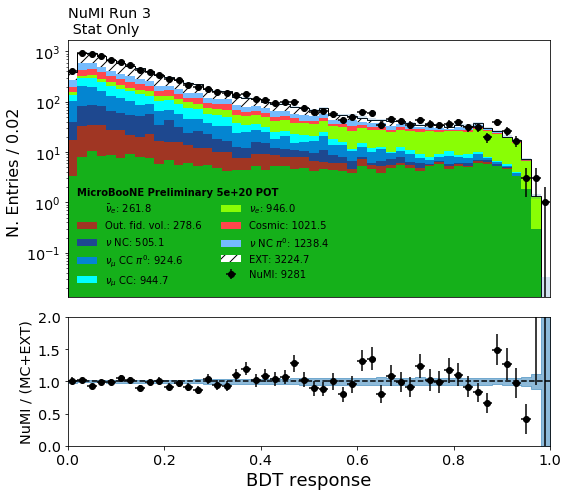

In [74]:
#QUERY += 'and reco_e < 0.15'
QUERY = "nslice == 1" #ZPLOOSESEL #ZPLOOSESEL
plots = [] 
sysBool = False
if USEBDT:
    plots.append(['bkg_score',50,(0,1.0),"BDT response"])
    
    
for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        draw_sys=sysBool,
        draw_geoSys = sysBool, 
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    
    if sysBool:
        ax1.set_title('NuMI Run 3 \nHP, Beamline Geo, GENIE, G4Reint Systematics',loc='left')
        ax1.set_yscale('log')
        fig.tight_layout()
        fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/AntiNueXS/Run3/PreSel/"+VARIABLE+"_Sys.pdf")
    else:
        ax1.set_title('NuMI Run 3 \n Stat Only',loc='left')
        ax1.set_yscale('log')
        fig.tight_layout()
        fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/AntiNueXS/Run3/PreSel/"+VARIABLE+"_StatOnly.pdf")

In [ ]:
QUERY =  ZPBDT
f = nue.query("nslice == 1 and nu_pdg  == 12")[["nu_e","nu_pdg","weightSplineTimesTuneTimesPPFX","weightSplineTimesPPFX","interaction"]]
f.to_csv("mc_run3_NuMI_Check.csv")

f = nue.query("nslice == 1 and nu_pdg  == -12")[["nu_e","nu_pdg","weightSplineTimesTuneTimesPPFX","weightSplineTimesPPFX","interaction"]]
f.to_csv("mc_run3_NuMIBar_Check.csv")

f = nue.query(QUERY+" and nu_pdg  == 12")[["nu_e","nu_pdg","weightSplineTimesTuneTimesPPFX","weightSplineTimesPPFX","interaction"]]
f.to_csv("mc_Sel_run3_1e0p_NuMI.csv")

f = nue.query(QUERY+" and nu_pdg  == -12")[["nu_e","nu_pdg","weightSplineTimesTuneTimesPPFX","weightSplineTimesPPFX","interaction"]]
f.to_csv("mc_Sel_run3_1e0p_NuMIBar.csv")

In [ ]:
#QUERY += 'and reco_e < 0.15'
QUERY = ZPBDT #ZPLOOSESEL
plots = [] 
plots.append(['shr_theta',10,(0,3.0),"Shower theta"])
plots.append(['reco_e', 15, (0.15,3.15), r"Reconstructed Energy [GeV]"])
plots.append(['pt',10,(0,2.),"Pt [GeV]"])
plots.append(['shr_phi',6,(-3.15,3.15),"Shower phi"])
plots.append(['shr_energy_tot_cali',15,(0.15,3.15),"shr energy (calibrated) [GeV]"])

for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=True,
        draw_geoSys = True, 
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    #ax1.set_ylim(0,ax1.get_ylim()[1]*1.4)
    #ax1.set_yscale("log")
    #fig.show()
    #ax1.set_title('NuMI Run 1 \n1eNp Loose Box Cuts - No pi0 scaling',loc='left')
    ax1.set_title('NuMI Run 1, 1e0p Final Sel -- Updated GENIE tune \nHP, Beamline Geo, GENIE, G4Reint Systematics',loc='left')
    fig.tight_layout()
    #fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/"+VARIABLE+".pdf")
    print('%s %.4f ' % (VARIABLE, my_plotter.stats['pvaluestatonly']))
    fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1e0p/PartialSys/BDTSel/"+VARIABLE+"_finalSel.pdf")
    #fig.savefig(ls.plots_path+""+VARIABLE+"_highscore.pdf")
    #break
    



In [ ]:
print('%s %.4f ' % (VARIABLE, my_plotter.stats['pvaluestatonly']))

In [ ]:
#QUERY += 'and reco_e < 0.15'
QUERY = "nslice == 1" #ZPBDT #ZPLOOSESEL
plots = [] 
plots.append(['reco_nu_vtx_sce_x',50,(0,260),"vtx x [cm]"])
plots.append(['reco_nu_vtx_sce_y',50,(-120,120),"vtx y [cm]"])
plots.append(['reco_nu_vtx_sce_z',50,(0,1030),"vtx z [cm]"])

'''
plots.append(['shr_theta',10,(0,3.0),"Shower theta"])
plots.append(['pt',10,(0,2.),"Pt [GeV]"])
plots.append(['shr_phi',10,(-3,3),"Shower phi"])
plots.append(['shr_energy_tot_cali',40,(0,2.),"shr energy (calibrated) [GeV]"])




plots.append(['reco_e', 20, (0.05,2.05), 'Reconstructed Energy [GeV]'])
plots.append(['reco_nu_vtx_sce_x',10,(0,260),"vtx x [cm]"])
plots.append(['reco_nu_vtx_sce_y',10,(-120,120),"vtx y [cm]"])
plots.append(['reco_nu_vtx_sce_z',10,(0,1030),"vtx z [cm]"])


plots.append(['trk_energy_tot',40,(0,0.01),"tracks energy [GeV]"])
plots.append(['shr_tkfit_2cm_dedx_Y',40,(0,20),"shr tkfit dE/dx (Y, 0-2 cm) [MeV/cm]"])
plots.append(['shr_tkfit_2cm_dedx_U',40,(0,20),"shr tkfit dE/dx (U, 0-2 cm) [MeV/cm]"])
plots.append(['shr_tkfit_2cm_dedx_V',40,(0,20),"shr tkfit dE/dx (V, 0-2 cm) [MeV/cm]"])
plots.append(['shr_tkfit_gap10_dedx_Y',40,(0,20),"shr tkfit dE/dx (Y, 1-5 cm) [MeV/cm]"])
plots.append(['shr_tkfit_gap10_dedx_U',40,(0,20),"shr tkfit dE/dx (U, 1-5 cm) [MeV/cm]"])
plots.append(['shr_tkfit_gap10_dedx_V',40,(0,20),"shr tkfit dE/dx (V, 1-5 cm) [MeV/cm]"])
plots.append(['shr_score',20,(0,0.5),"shr score"])
plots.append(['trkfit',10,(0,1),"Fraction of Track-fitted points"])
plots.append(['subcluster',15,(0,60),"N sub-clusters in shower"])
plots.append(['shrmoliereavg',10,(0,25),"average Moliere angle [degrees]"])
plots.append(['CosmicIPAll3D',10,(0,200),"CosmicIPAll3D [cm]"])
plots.append(['CosmicDirAll3D',10,(-1,1),"cos(CosmicDirAll3D)"])
plots.append(['anglediff_Y',10,(0,360),"angle diff 1st-2nd shower (Y) [degrees]"])
plots.append(['anglediff_V',10,(0,360),"angle diff 1st-2nd shower (V) [degrees]"])
plots.append(['anglediff_U',10,(0,360),"angle diff 1st-2nd shower (U) [degrees]"])
plots.append(['secondshower_Y_nhit',25,(0,500),"Nhit 2nd shower (Y)"])
plots.append(['secondshower_V_nhit',25,(0,500),"Nhit 2nd shower (V)"])
plots.append(['secondshower_U_nhit',25,(0,500),"Nhit 2nd shower (U)"])
plots.append(['secondshower_Y_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (Y)"])
plots.append(['secondshower_V_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (V)"])
plots.append(['secondshower_U_dot',20,(-1,1),"cos(2nd shower direction wrt vtx) (U)"])
plots.append(['secondshower_Y_vtxdist',20,(0.,1000),"vtx dist 2nd shower (Y)"])
plots.append(['secondshower_V_vtxdist',20,(0.,1000),"vtx dist 2nd shower (V)"])
plots.append(['secondshower_U_vtxdist',20,(0.,1000),"vtx dist 2nd shower (U)"])
plots.append(['CylFrac2h_1cm',10,(0,1.),"CylFrac2h 1cm"])
plots.append(['shrPCA1CMed_5cm',20,(0.5,1),"shrPCA1CMed 5cm"])
plots.append(['DeltaRMS2h',20,(0,20),"DeltaRMS2h 1cm"])
plots.append(['shrMCSMom',20,(0,1000),"shrMCSMom 1cm"])
'''
if USEBDT:
    plots.append(['bkg_score',10,(0,1.0),"BDT response"])




#plots.append(['tksh_distance',5,(0,5),"tksh distance [cm]"])
#plots.append(['tksh_angle',10,(-1,1),"cos(tksh angle)"])
#plots.append(['shr_tkfit_dedx_max',15,(0,10),"shr tkfit dE/dx (best-plane, 0-4 cm) [MeV/cm]"])
#plots.append(['trkpid',10,(-1,1),"track LLR PID"])
#plots.append(['hits_ratio',20,(0,1),"shower hits/all hits"])
#plots.append(['trkshrhitdist2',16,(-1,15),"2D trk-shr distance (Y)"])
#plots.append(['reco_nu_vtx_sce_y',15,(-150,150),"reco nu vtx y [cm]"])
             
#plots.append(['shr_tkfit_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_2cm_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-2 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_dedx_avg',20,(0,10),"shr tkfit dE/dx (avg, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_gap10_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 1-5 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_nhits_tot',20,(0,20),"shr tkfit nhits (tot, 0-4 cm) [MeV/cm]"])
#plots.append(['shr_tkfit_dedx_max',20,(0,10),"shr tkfit dE/dx (best-plane, 0-4 cm) [MeV/cm]"])
#plots.append(['n_showers_contained',10,(0,10),"n showers contained"])
#plots.append(['n_tracks_contained',5,(0,5),"n tracks contained"])
#plots.append(['protonenergy',10,(0.,0.5),"Proton Kinetic Energy [GeV]"])
#plots.append(['trk_theta',10,(0,3.0),"Track theta"])
#plots.append(['reco_nu_vtx_sce_z',20,(0,1100),"z"])
#plots.append(['reco_e_rqe',20,(0,2),"rqe"])
#plots.append(['shrmoliererms',20,(0,5000),"RMS Moliere angle [degrees]"])
#plots.append(['shr_energy_tot_cali',20,(0,1),"shr energy (calibrated) [GeV]"])
#plots.append(['contained_fraction',20,(0.,1),"contained fraction"])
#plots.append(['hits_y',20,(0.,1000),"N hits Y plane"])
#plots.append(['pi0_mass_Y',25,(-50.,200),"pi0 mass [Mev]"])
#plots.append(['pi0_gammadot',20,(-1,1),"2-shower angle"])


    
for VARIABLE, BINS, RANGE, XTIT in plots:
    print(VARIABLE, BINS, RANGE, XTIT)
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,
        kind="event_category",
        #kind="interaction",
        #kind="sample",
        draw_sys=True,
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE,
    )[0:3]
    #ax1.set_ylim(0,ax1.get_ylim()[1]*1.4)
    #ax1.set_yscale("log")
    #fig.show()
    #ax1.set_title('NuMI Run 1 \n1eNp Loose Box Cuts - No pi0 scaling',loc='left')
    ax1.set_title('NuMI Run 1 \n1e0p Loose Sel - Pi0 Scaling: [1-0.4 E_pi0]',loc='left')
    fig.tight_layout()
    #fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/Sidebands/Figures/NuMI/1eNp/"+VARIABLE+".pdf")
    print('%s %.4f ' % (VARIABLE, my_plotter.stats['pvaluestatonly']))
    fig.savefig("/Users/elenag/Desktop/NuMI/NuMI4PeLEE/AntiNueXS/Run3/"+VARIABLE+"_PreSel.pdf")
    #fig.savefig(ls.plots_path+""+VARIABLE+"_highscore.pdf")
    #break

In [ ]:
QUERY2 = QUERY + " and shr_tkfit_2cm_dedx_U < 0."
f = data.query(QUERY2)[["run","sub","shr_tkfit_2cm_dedx_U"]]#.to_string(index=False)
print(f.sort_values("run").to_string(),f.shape[0])
QUERY2 = QUERY + " and shr_tkfit_2cm_dedx_V < 0."
f = data.query(QUERY2)[["run","sub","shr_tkfit_2cm_dedx_V"]]#.to_string(index=False)
print(f.sort_values("run").to_string(),f.shape[0])
QUERY2 = QUERY + " and shr_tkfit_2cm_dedx_Y < 0."
f = data.query(QUERY2)[["run","sub","shr_tkfit_2cm_dedx_Y"]]#.to_string(index=False)
print(f.sort_values("run").to_string(),f.shape[0])

QUERY2 = QUERY + " and shr_tkfit_gap10_dedx_U < 0."
f = data.query(QUERY2)[["run","sub","shr_tkfit_gap10_dedx_U"]]#.to_string(index=False)
print(f.sort_values("run").to_string(),f.shape[0])
QUERY2 = QUERY + " and shr_tkfit_gap10_dedx_V < 0."
f = data.query(QUERY2)[["run","sub","shr_tkfit_gap10_dedx_V"]]#.to_string(index=False)
print(f.sort_values("run").to_string(),f.shape[0])
QUERY2 = QUERY + " and shr_tkfit_gap10_dedx_Y < 0."
f = data.query(QUERY2)[["run","sub","shr_tkfit_gap10_dedx_Y"]]#.to_string(index=False)
print(f.sort_values("run").to_string(),f.shape[0])


#query4SamWeb = f.apply(lambda x: str(x['run'])+'.'+str(x['sub'])+',', axis=1).sum()
#print("defname: numi_uboone_run1_beamon_offset1_mcc9_reco2_v08_00_00_28_v0 and run_number "+query4SamWeb)

#f = data.query(QUERY2)[["run","sub","evt","shr_tkfit_gap10_dedx_V"]]


In [ ]:
QUERY2 = QUERY + " and reco_e >= 0.15"
f     = data.query(QUERY2)[["shr_tkfit_2cm_dedx_U","shr_tkfit_2cm_dedx_V","shr_tkfit_2cm_dedx_Y","shr_tkfit_gap10_dedx_U","shr_tkfit_gap10_dedx_V","shr_tkfit_gap10_dedx_Y"]]#.to_string(index=False)
puppa = (f<0).sum(axis=1) > 0
print ((f<0).sum(axis=1) > 0, puppa.shape[0] )
print (puppa.sum(axis=0))
#print(f.to_string(),f.shape[0],puppa.shape[0])

In [ ]:
QUERY2 = QUERY
f = data.query(QUERY2)[["run","sub","evt"]]#.to_string(index=False)
print(f.sort_values("run").to_string(),f.shape[0])

#query4SamWeb = f.apply(lambda x: str(x['run'])+'.'+str(x['sub'])+',', axis=1).sum()
#print("defname: numi_uboone_run1_beamon_offset1_mcc9_reco2_v08_00_00_28_beam_good and run_number "+query4SamWeb)


In [ ]:
print(ZPLOOSESEL)